In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import class_weight
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv("LSTM_1_6.csv")

print("Shape:", df.shape)
df

Shape: (6096, 66)


,frame,Gesture,x_0,x_1,x_2,x_3,x_4,x_5,x_6,x_7,...,z_12,z_13,z_14,z_15,z_16,z_17,z_18,z_19,z_20,clip_id
0,6,0,0.439152,0.410372,0.392198,0.379121,0.368621,0.413687,0.389965,0.382798,...,0.015359,0.013906,0.018745,0.016704,0.014214,0.011729,0.016528,0.018544,0.019494,clip1
1,7,0,0.446880,0.420233,0.400958,0.386086,0.375873,0.417231,0.396619,0.386996,...,0.010964,0.013766,0.016467,0.014878,0.013508,0.018862,0.020266,0.020490,0.021125,clip1
2,8,0,0.448999,0.424995,0.409311,0.397226,0.389651,0.437639,0.419415,0.402987,...,-0.001331,0.004053,0.004623,0.004954,0.004872,0.010908,0.010748,0.011465,0.012303,clip1
3,9,0,0.461615,0.435223,0.419272,0.408268,0.399821,0.437466,0.415694,0.402070,...,0.003926,0.006740,0.004849,0.002583,0.001818,0.006266,0.003407,0.003586,0.004994,clip1
4,10,0,0.466189,0.442301,0.426694,0.414771,0.407884,0.452656,0.433908,0.417616,...,0.010562,0.017282,0.019520,0.016679,0.014452,0.023631,0.024325,0.023688,0.023627,clip1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6091,7177,0,0.395888,0.358894,0.333479,0.314093,0.297802,0.385549,0.371069,0.351853,...,-0.035769,-0.027164,-0.032981,-0.022423,-0.012188,-0.011186,-0.014968,-0.010836,-0.004923,clip2
6092,7178,0,0.406378,0.367929,0.345697,0.333675,0.318458,0.409847,0.392670,0.367901,...,-0.062162,-0.032890,-0.043874,-0.041723,-0.038970,-0.013855,-0.023703,-0.026186,-0.026672,clip2
6093,7179,0,0.423236,0.387279,0.368105,0.362933,0.353950,0.445148,0.440082,0.412516,...,-0.093475,-0.039322,-0.059908,-0.063745,-0.063149,-0.015400,-0.031058,-0.035359,-0.035888,clip2
6094,7180,0,0.435217,0.409907,0.405242,0.408530,0.410300,0.488315,0.499606,0.472815,...,-0.117260,-0.037740,-0.063485,-0.077922,-0.084394,-0.016269,-0.034210,-0.043090,-0.047416,clip2


In [3]:
df['Gesture'].value_counts()

Gesture
1    2165
2    1396
5    1092
0     705
4     601
3     137
Name: count, dtype: int64

In [4]:
for axis in ['x', 'y', 'z']:
    for i in range(21):
        col = f'{axis}_{i}'
        df[f'vel_{col}'] = df[col].diff().fillna(0) 

In [5]:
df

,frame,Gesture,x_0,x_1,x_2,x_3,x_4,x_5,x_6,x_7,...,vel_z_11,vel_z_12,vel_z_13,vel_z_14,vel_z_15,vel_z_16,vel_z_17,vel_z_18,vel_z_19,vel_z_20
0,6,0,0.439152,0.410372,0.392198,0.379121,0.368621,0.413687,0.389965,0.382798,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,7,0,0.446880,0.420233,0.400958,0.386086,0.375873,0.417231,0.396619,0.386996,...,-0.006657,-0.004395,-0.000140,-0.002279,-0.001826,-0.000705,0.007132,0.003738,0.001946,0.001631
2,8,0,0.448999,0.424995,0.409311,0.397226,0.389651,0.437639,0.419415,0.402987,...,-0.013300,-0.012295,-0.009713,-0.011844,-0.009924,-0.008636,-0.007953,-0.009517,-0.009024,-0.008822
3,9,0,0.461615,0.435223,0.419272,0.408268,0.399821,0.437466,0.415694,0.402070,...,0.006638,0.005258,0.002688,0.000226,-0.002371,-0.003055,-0.004642,-0.007341,-0.007880,-0.007309
4,10,0,0.466189,0.442301,0.426694,0.414771,0.407884,0.452656,0.433908,0.417616,...,0.007009,0.006636,0.010541,0.014672,0.014096,0.012634,0.017365,0.020917,0.020102,0.018633
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6091,7177,0,0.395888,0.358894,0.333479,0.314093,0.297802,0.385549,0.371069,0.351853,...,-0.023305,-0.023663,-0.010670,-0.017244,-0.018276,-0.018251,-0.007506,-0.013574,-0.016823,-0.018968
6092,7178,0,0.406378,0.367929,0.345697,0.333675,0.318458,0.409847,0.392670,0.367901,...,-0.020176,-0.026392,-0.005726,-0.010893,-0.019301,-0.026782,-0.002669,-0.008735,-0.015350,-0.021749
6093,7179,0,0.423236,0.387279,0.368105,0.362933,0.353950,0.445148,0.440082,0.412516,...,-0.028146,-0.031313,-0.006432,-0.016033,-0.022022,-0.024179,-0.001545,-0.007355,-0.009173,-0.009217
6094,7180,0,0.435217,0.409907,0.405242,0.408530,0.410300,0.488315,0.499606,0.472815,...,-0.014895,-0.023785,0.001582,-0.003577,-0.014177,-0.021245,-0.000869,-0.003152,-0.007731,-0.011527


In [11]:
def calculate_angle(df, a, b, c, feature_name):
    a_xyz = df[[f'x_{a}', f'y_{a}', f'z_{a}']].values
    b_xyz = df[[f'x_{b}', f'y_{b}', f'z_{b}']].values
    c_xyz = df[[f'x_{c}', f'y_{c}', f'z_{c}']].values

    ab = a_xyz - b_xyz
    cb = c_xyz - b_xyz

    dot_product = np.sum(ab * cb, axis=1)
    norm_product = np.linalg.norm(ab, axis=1) * np.linalg.norm(cb, axis=1)

    cosine_angle = dot_product / (norm_product + 1e-8)
    angle_rad = np.arccos(np.clip(cosine_angle, -1.0, 1.0))  # radian
    angle_deg = np.degrees(angle_rad)

    df[feature_name] = angle_deg
    return df

df = calculate_angle(df, a=0, b=5, c=17, feature_name='angle_hand_open')

df = calculate_angle(df, a=0, b=9, c=13, feature_name='angle_palm_curve')  
df = calculate_angle(df, a=5, b=6, c=7, feature_name='angle_index_flex')   
df = calculate_angle(df, a=17, b=18, c=19, feature_name='angle_pinky_flex')  

df = calculate_angle(df, a=4, b=0, c=8, feature_name='angle_thumb_index')

In [13]:
df

,frame,Gesture,x_0,x_1,x_2,x_3,x_4,x_5,x_6,x_7,...,vel_z_16,vel_z_17,vel_z_18,vel_z_19,vel_z_20,angle_hand_open,angle_palm_curve,angle_index_flex,angle_pinky_flex,angle_thumb_index
0,6,0,0.439152,0.410372,0.392198,0.379121,0.368621,0.413687,0.389965,0.382798,...,0.000000,0.000000,0.000000,0.000000,0.000000,31.200451,25.519493,100.814593,130.354130,7.399096
1,7,0,0.446880,0.420233,0.400958,0.386086,0.375873,0.417231,0.396619,0.386996,...,-0.000705,0.007132,0.003738,0.001946,0.001631,65.994796,64.229158,118.481122,126.798748,8.188769
2,8,0,0.448999,0.424995,0.409311,0.397226,0.389651,0.437639,0.419415,0.402987,...,-0.008636,-0.007953,-0.009517,-0.009024,-0.008822,51.135669,52.120642,109.041908,111.354451,4.270956
3,9,0,0.461615,0.435223,0.419272,0.408268,0.399821,0.437466,0.415694,0.402070,...,-0.003055,-0.004642,-0.007341,-0.007880,-0.007309,136.241563,142.474950,117.674215,108.375432,4.443524
4,10,0,0.466189,0.442301,0.426694,0.414771,0.407884,0.452656,0.433908,0.417616,...,0.012634,0.017365,0.020917,0.020102,0.018633,81.695073,78.455414,125.752460,115.885630,4.292463
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6091,7177,0,0.395888,0.358894,0.333479,0.314093,0.297802,0.385549,0.371069,0.351853,...,-0.018251,-0.007506,-0.013574,-0.016823,-0.018968,74.160758,82.597333,141.147101,159.557286,12.694532
6092,7178,0,0.406378,0.367929,0.345697,0.333675,0.318458,0.409847,0.392670,0.367901,...,-0.026782,-0.002669,-0.008735,-0.015350,-0.021749,83.617842,94.209980,144.695057,163.241609,9.870262
6093,7179,0,0.423236,0.387279,0.368105,0.362933,0.353950,0.445148,0.440082,0.412516,...,-0.024179,-0.001545,-0.007355,-0.009173,-0.009217,86.128758,96.762222,149.187745,155.443188,9.469518
6094,7180,0,0.435217,0.409907,0.405242,0.408530,0.410300,0.488315,0.499606,0.472815,...,-0.021245,-0.000869,-0.003152,-0.007731,-0.011527,90.348025,101.343888,149.181866,155.247247,9.626632


In [15]:
df.columns

Index(['frame', 'Gesture', 'x_0', 'x_1', 'x_2', 'x_3', 'x_4', 'x_5', 'x_6',
       'x_7',
       ...
       'vel_z_16', 'vel_z_17', 'vel_z_18', 'vel_z_19', 'vel_z_20',
       'angle_hand_open', 'angle_palm_curve', 'angle_index_flex',
       'angle_pinky_flex', 'angle_thumb_index'],
      dtype='object', length=134)

Epoch 1/50


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


15/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4568 - loss: 0.9027   
Epoch 1: val_accuracy improved from -inf to 0.70811, saving model to best_lstm_model.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.4955 - loss: 0.8605 - val_accuracy: 0.7081 - val_loss: 0.6846
Epoch 2/50
16/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6712 - loss: 0.5951 
Epoch 2: val_accuracy improved from 0.70811 to 0.71892, saving model to best_lstm_model.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6834 - loss: 0.5819 - val_accuracy: 0.7189 - val_loss: 0.6060
Epoch 3/50
16/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7294 - loss: 0.5169
Epoch 3: val_accuracy improved from 0.71892 to 0.74054, saving model to best_lstm_model.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7281 - loss: 0.5129 - val_accuracy: 0.7405 - val_loss: 0.5789
Epoch 4/50
21/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7581 - loss: 0.4736 
Epoch 4: val_accuracy improved from 0.74054 to 0.75135, saving model to best_lstm_model.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7580 - loss: 0.4743 - val_accuracy: 0.7514 - val_loss: 0.5427
Epoch 5/50
15/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7565 - loss: 0.4705 
Epoch 5: val_accuracy did not improve from 0.75135
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7547 - loss: 0.4669 - val_accuracy: 0.7297 - val_loss: 0.5364
Epoch 6/50
15/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7508 - loss: 0.4471 
Epoch 6: val_accuracy did not improve from 0.75135
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7560 - loss: 0.4469 - val_accuracy: 0.7405 - val_loss: 0.5108
Epoch 7/50
15/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8099 - loss: 0.4085
Epoch 7: val_accuracy improved from 0.75135 to 0.76216, saving model to best_lstm_model.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8115 - loss: 0.4041 - val_accuracy: 0.7622 - val_loss: 0.5012
Epoch 8/50
15/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8208 - loss: 0.3554 
Epoch 8: val_accuracy improved from 0.76216 to 0.78919, saving model to best_lstm_model.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8173 - loss: 0.3619 - val_accuracy: 0.7892 - val_loss: 0.4993
Epoch 9/50
14/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8385 - loss: 0.3638 
Epoch 9: val_accuracy did not improve from 0.78919
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8292 - loss: 0.3676 - val_accuracy: 0.7784 - val_loss: 0.4546
Epoch 10/50
15/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8584 - loss: 0.3545 
Epoch 10: val_accuracy did not improve from 0.78919
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8513 - loss: 0.3501 - val_accuracy: 0.7784 - val_loss: 0.4845
Epoch 11/50
15/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8428 - loss: 0.3136 
Epoch 11: val_accuracy did not improve from 0.78919
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8429 - loss: 0.3164 - val_accuracy: 0.7838 - val_loss: 0.4799
Epoch 12/50
16/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8464 - loss: 0.3314 
Epoch 12: val_accuracy did not improve fro

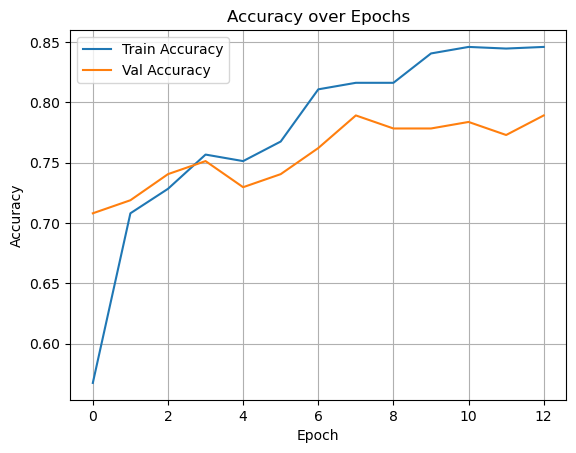

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Confusion Matrix:
[[57 27  2]
 [ 8 47  0]
 [ 2  0 42]]

Classification Report:
              precision    recall  f1-score   support

     label_1       0.85      0.66      0.75        86
     label_2       0.64      0.85      0.73        55
     label_5       0.95      0.95      0.95        44

    accuracy                           0.79       185
   macro avg       0.81      0.82      0.81       185
weighted avg       0.81      0.79      0.79       185



In [18]:
for axis in ['x', 'y', 'z']:
    base = df[f'{axis}_0']
    for i in range(21):
        df[f'{axis}_{i}'] = df[f'{axis}_{i}'] - base

landmark_cols = [col for col in df.columns if col.startswith(('x_', 'y_', 'z_'))]
scaler = StandardScaler()
df[landmark_cols] = scaler.fit_transform(df[landmark_cols])

df = df[df['Gesture'].isin([1, 2, 5])].copy()
label_map = {1: 0, 2: 1, 5: 2}
df['label'] = df['Gesture'].map(label_map)

def create_sequences(df, window_size=30, step=5):
    X, y = [], []
    features = df[[col for col in df.columns if col.startswith(('x_', 'y_', 'z_'))]].values
    labels = df['label'].values
    for i in range(0, len(df) - window_size + 1, step):
        X.append(features[i:i + window_size])
        y.append(labels[i + window_size - 1])
    return np.array(X), np.array(y)

X_seq, y_seq = create_sequences(df)

X_train, X_val, y_train, y_val = train_test_split(
    X_seq, y_seq, test_size=0.2, stratify=y_seq, random_state=42
)
y_train_cat = to_categorical(y_train, num_classes=3)
y_val_cat = to_categorical(y_val, num_classes=3)

cw = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(cw))

model = Sequential([
    LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dense(3, activation='softmax')
])
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_lstm_model.h5', monitor='val_accuracy', save_best_only=True, verbose=1)

history = model.fit(
    X_train, y_train_cat,
    validation_data=(X_val, y_val_cat),
    epochs=50,
    batch_size=32,
    class_weight=class_weights,
    callbacks=[early_stop, checkpoint],
    verbose=1
)

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid()
plt.legend()
plt.show()

y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_val_cat, axis=1)

print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred_classes))
print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=["label_1", "label_2", "label_5"]))

Epoch 1/50


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4211 - loss: 1.0673   
Epoch 1: val_accuracy improved from -inf to 0.62162, saving model to best_lstm_model.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.4859 - loss: 0.9819 - val_accuracy: 0.6216 - val_loss: 0.6801
Epoch 2/50
13/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6657 - loss: 0.5917 
Epoch 2: val_accuracy improved from 0.62162 to 0.71351, saving model to best_lstm_model.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6802 - loss: 0.5773 - val_accuracy: 0.7135 - val_loss: 0.6078
Epoch 3/50
13/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7390 - loss: 0.5569 
Epoch 3: val_accuracy improved from 0.71351 to 0.77297, saving model to best_lstm_model.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7519 - loss: 0.5237 - val_accuracy: 0.7730 - val_loss: 0.5407
Epoch 4/50
13/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7603 - loss: 0.4919 
Epoch 4: val_accuracy improved from 0.77297 to 0.77838, saving model to best_lstm_model.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7653 - loss: 0.4706 - val_accuracy: 0.7784 - val_loss: 0.4975
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8068 - loss: 0.3667
Epoch 5: val_accuracy did not improve from 0.77838
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8073 - loss: 0.3667 - val_accuracy: 0.7784 - val_loss: 0.4895
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8304 - loss: 0.3448
Epoch 6: val_accuracy did not improve from 0.77838
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8308 - loss: 0.3447 - val_accuracy: 0.7730 - val_loss: 0.4723
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8552 - loss: 0.3012
Epoch 7: val_accuracy improved from 0.77838 to 0.80541, saving model to best_lstm_model.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8550 - loss: 0.3014 - val_accuracy: 0.8054 - val_loss: 0.4318
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8615 - loss: 0.3045
Epoch 8: val_accuracy did not improve from 0.80541
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8611 - loss: 0.3046 - val_accuracy: 0.7838 - val_loss: 0.4375
Epoch 9/50
20/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8538 - loss: 0.2867
Epoch 9: val_accuracy improved from 0.80541 to 0.81081, saving model to best_lstm_model.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8564 - loss: 0.2850 - val_accuracy: 0.8108 - val_loss: 0.3985
Epoch 10/50
23/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8600 - loss: 0.3000
Epoch 10: val_accuracy improved from 0.81081 to 0.81622, saving model to best_lstm_model.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8600 - loss: 0.3010 - val_accuracy: 0.8162 - val_loss: 0.3820
Epoch 11/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8805 - loss: 0.2473
Epoch 11: val_accuracy improved from 0.81622 to 0.82703, saving model to best_lstm_model.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8805 - loss: 0.2476 - val_accuracy: 0.8270 - val_loss: 0.3894
Epoch 12/50
13/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8827 - loss: 0.2620 
Epoch 12: val_accuracy improved from 0.82703 to 0.83784, saving model to best_lstm_model.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8915 - loss: 0.2494 - val_accuracy: 0.8378 - val_loss: 0.3771
Epoch 13/50
13/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9053 - loss: 0.2168 
Epoch 13: val_accuracy improved from 0.83784 to 0.84324, saving model to best_lstm_model.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9011 - loss: 0.2154 - val_accuracy: 0.8432 - val_loss: 0.3737
Epoch 14/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8889 - loss: 0.2226
Epoch 14: val_accuracy did not improve from 0.84324
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8893 - loss: 0.2222 - val_accuracy: 0.8378 - val_loss: 0.3716
Epoch 15/50
21/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8983 - loss: 0.2229
Epoch 15: val_accuracy improved from 0.84324 to 0.85405, saving model to best_lstm_model.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8979 - loss: 0.2216 - val_accuracy: 0.8541 - val_loss: 0.3816
Epoch 16/50
23/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9045 - loss: 0.2246
Epoch 16: val_accuracy did not improve from 0.85405
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9047 - loss: 0.2235 - val_accuracy: 0.8270 - val_loss: 0.3720
Epoch 17/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9244 - loss: 0.1629
Epoch 17: val_accuracy did not improve from 0.85405
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9242 - loss: 0.1631 - val_accuracy: 0.8378 - val_loss: 0.3626
Epoch 18/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9281 - loss: 0.1665
Epoch 18: val_accuracy did not improve from 0.85405
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9282 - loss: 0.1663 - val_accuracy: 0.8324 - val_loss: 0.3607
Epoch 19/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9314 - loss: 0.1500
Epoch 19: val_accuracy did not improve from 

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9303 - loss: 0.1398 - val_accuracy: 0.8649 - val_loss: 0.3606
Epoch 21/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9387 - loss: 0.1334
Epoch 21: val_accuracy improved from 0.86486 to 0.87027, saving model to best_lstm_model.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9387 - loss: 0.1339 - val_accuracy: 0.8703 - val_loss: 0.3783
Epoch 22/50
13/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9242 - loss: 0.1417 
Epoch 22: val_accuracy did not improve from 0.87027
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9299 - loss: 0.1396 - val_accuracy: 0.8595 - val_loss: 0.3765
Epoch 23/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9485 - loss: 0.1241
Epoch 23: val_accuracy did not improve from 0.87027
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9485 - loss: 0.1241 - val_accuracy: 0.8649 - val_loss: 0.3575
Epoch 24/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9709 - loss: 0.0961
Epoch 24: val_accuracy did not improve from 0.87027
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9704 - loss: 0.0969 - val_accuracy: 0.8432 - val_loss: 0.3980
Epoch 25/50
23/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9509 - loss: 0.1116
Epoch 25: val_accuracy did not improve from

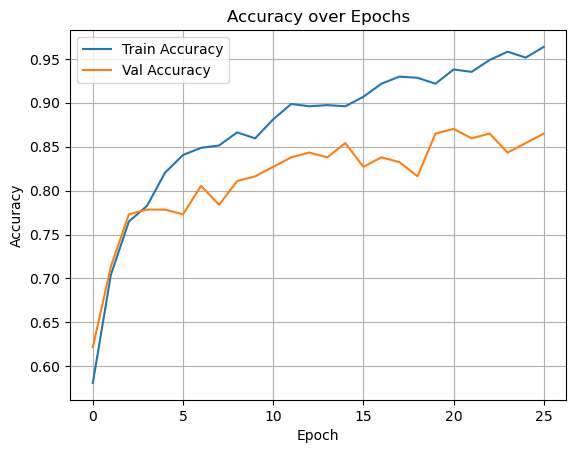

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Confusion Matrix:
[[68 16  2]
 [ 6 49  0]
 [ 0  0 44]]

Classification Report:
              precision    recall  f1-score   support

     label_1       0.92      0.79      0.85        86
     label_2       0.75      0.89      0.82        55
     label_5       0.96      1.00      0.98        44

    accuracy                           0.87       185
   macro avg       0.88      0.89      0.88       185
weighted avg       0.88      0.87      0.87       185



In [17]:
for axis in ['x', 'y', 'z']:
    base = df[f'{axis}_0']
    for i in range(21):
        df[f'{axis}_{i}'] = df[f'{axis}_{i}'] - base

df = df[df['Gesture'].isin([1, 2, 5])].copy()
label_map = {1: 0, 2: 1, 5: 2}
df['label'] = df['Gesture'].map(label_map)

xyz_cols = [col for col in df.columns if col.startswith(('x_', 'y_', 'z_'))]
vel_cols = [col for col in df.columns if col.startswith('vel_')]
angle_cols = [col for col in df.columns if col.startswith('angle_')]
all_feature_cols = xyz_cols + vel_cols + angle_cols

scaler = StandardScaler()
df[all_feature_cols] = scaler.fit_transform(df[all_feature_cols])

def create_sequences(df, feature_cols, window_size=30, step=5):
    X, y = [], []
    data = df[feature_cols].values
    labels = df['label'].values
    for i in range(0, len(df) - window_size + 1, step):
        X.append(data[i:i+window_size])
        y.append(labels[i+window_size - 1])
    return np.array(X), np.array(y)

X_seq, y_seq = create_sequences(df, all_feature_cols)

X_train, X_val, y_train, y_val = train_test_split(
    X_seq, y_seq, test_size=0.2, stratify=y_seq, random_state=42
)
y_train_cat = to_categorical(y_train, num_classes=3)
y_val_cat = to_categorical(y_val, num_classes=3)

cw = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(cw))

model = Sequential([
    LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dense(3, activation='softmax')
])
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_lstm_model.h5', monitor='val_accuracy', save_best_only=True, verbose=1)

history = model.fit(
    X_train, y_train_cat,
    validation_data=(X_val, y_val_cat),
    epochs=50,
    batch_size=32,
    class_weight=class_weights,
    callbacks=[early_stop, checkpoint],
    verbose=1
)

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.show()

y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_val_cat, axis=1)

print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred_classes))

print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=["label_1", "label_2", "label_5"]))


Epoch 1/50


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4317 - loss: 1.0376   
Epoch 1: val_accuracy improved from -inf to 0.70811, saving model to best_lstm_model.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.4998 - loss: 0.9500 - val_accuracy: 0.7081 - val_loss: 0.6723
Epoch 2/50
22/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6897 - loss: 0.5796
Epoch 2: val_accuracy improved from 0.70811 to 0.76216, saving model to best_lstm_model.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6898 - loss: 0.5806 - val_accuracy: 0.7622 - val_loss: 0.5919
Epoch 3/50
13/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7516 - loss: 0.4949 
Epoch 3: val_accuracy improved from 0.76216 to 0.77297, saving model to best_lstm_model.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7528 - loss: 0.4965 - val_accuracy: 0.7730 - val_loss: 0.5587
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7812 - loss: 0.4641
Epoch 4: val_accuracy improved from 0.77297 to 0.79459, saving model to best_lstm_model.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7814 - loss: 0.4636 - val_accuracy: 0.7946 - val_loss: 0.5129
Epoch 5/50
23/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8042 - loss: 0.3842
Epoch 5: val_accuracy improved from 0.79459 to 0.80000, saving model to best_lstm_model.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8053 - loss: 0.3853 - val_accuracy: 0.8000 - val_loss: 0.4665
Epoch 6/50
21/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8257 - loss: 0.3983
Epoch 6: val_accuracy improved from 0.80000 to 0.81622, saving model to best_lstm_model.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8271 - loss: 0.3940 - val_accuracy: 0.8162 - val_loss: 0.4449
Epoch 7/50
23/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8832 - loss: 0.3016
Epoch 7: val_accuracy improved from 0.81622 to 0.84324, saving model to best_lstm_model.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8818 - loss: 0.3040 - val_accuracy: 0.8432 - val_loss: 0.4096
Epoch 8/50
23/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8533 - loss: 0.3303
Epoch 8: val_accuracy did not improve from 0.84324
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8534 - loss: 0.3305 - val_accuracy: 0.8054 - val_loss: 0.4247
Epoch 9/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8820 - loss: 0.2897
Epoch 9: val_accuracy did not improve from 0.84324
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8813 - loss: 0.2901 - val_accuracy: 0.8270 - val_loss: 0.3885
Epoch 10/50
23/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8736 - loss: 0.2759
Epoch 10: val_accuracy did not improve from 0.84324
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8733 - loss: 0.2769 - val_accuracy: 0.7838 - val_loss: 0.4158
Epoch 11/50
23/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8711 - loss: 0.2674
Epoch 11: val_accuracy did not improve from 0.84

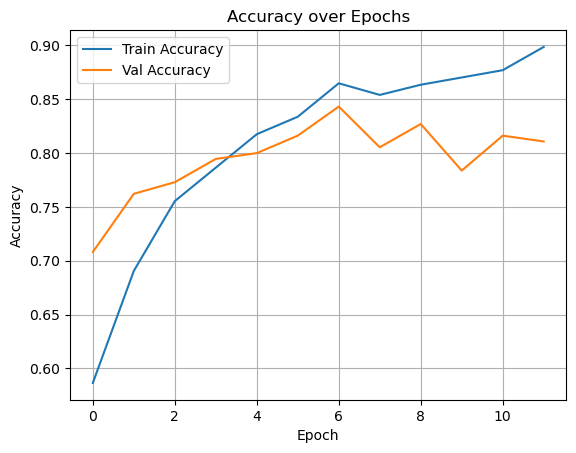

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Confusion Matrix:
[[68 16  2]
 [10 45  0]
 [ 1  0 43]]

Classification Report:
              precision    recall  f1-score   support

     label_1       0.86      0.79      0.82        86
     label_2       0.74      0.82      0.78        55
     label_5       0.96      0.98      0.97        44

    accuracy                           0.84       185
   macro avg       0.85      0.86      0.86       185
weighted avg       0.85      0.84      0.84       185



In [17]:
for axis in ['x', 'y', 'z']:
    base = df[f'{axis}_0']
    for i in range(21):
        df[f'{axis}_{i}'] = df[f'{axis}_{i}'] - base

df = df[df['Gesture'].isin([1, 2, 5])].copy()
label_map = {1: 0, 2: 1, 5: 2}
df['label'] = df['Gesture'].map(label_map)

xyz_cols = [col for col in df.columns if col.startswith(('x_', 'y_', 'z_'))]
vel_cols = [col for col in df.columns if col.startswith('vel_')]
angle_cols = [col for col in df.columns if col.startswith('angle_')]
all_feature_cols = xyz_cols + vel_cols + angle_cols

scaler = StandardScaler()
df[all_feature_cols] = scaler.fit_transform(df[all_feature_cols])

def create_sequences(df, feature_cols, window_size=30, step=5):
    X, y = [], []
    data = df[feature_cols].values
    labels = df['label'].values
    for i in range(0, len(df) - window_size + 1, step):
        X.append(data[i:i+window_size])
        y.append(labels[i+window_size - 1])
    return np.array(X), np.array(y)

X_seq, y_seq = create_sequences(df, all_feature_cols)

X_train, X_val, y_train, y_val = train_test_split(
    X_seq, y_seq, test_size=0.2, stratify=y_seq, random_state=42
)
y_train_cat = to_categorical(y_train, num_classes=3)
y_val_cat = to_categorical(y_val, num_classes=3)

cw = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(cw))

model = Sequential([
    LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False),
    Dropout(0.5),  
    Dense(64, activation='relu'),
    Dropout(0.3), 
    Dense(3, activation='softmax')
])
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_lstm_model.h5', monitor='val_accuracy', save_best_only=True, verbose=1)

history = model.fit(
    X_train, y_train_cat,
    validation_data=(X_val, y_val_cat),
    epochs=50,
    batch_size=32,
    class_weight=class_weights,
    callbacks=[early_stop, checkpoint],
    verbose=1
)

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.show()

y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_val_cat, axis=1)

print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred_classes))

print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=["label_1", "label_2", "label_5"]))

Epoch 1/50


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4038 - loss: 1.1357   
Epoch 1: val_accuracy improved from -inf to 0.67568, saving model to best_lstm_model.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4195 - loss: 1.1150 - val_accuracy: 0.6757 - val_loss: 0.8946
Epoch 2/50
 7/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5950 - loss: 0.8960 
Epoch 2: val_accuracy improved from 0.67568 to 0.70270, saving model to best_lstm_model.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6093 - loss: 0.8689 - val_accuracy: 0.7027 - val_loss: 0.7274
Epoch 3/50
19/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6236 - loss: 0.7395 
Epoch 3: val_accuracy improved from 0.70270 to 0.70811, saving model to best_lstm_model.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6283 - loss: 0.7319 - val_accuracy: 0.7081 - val_loss: 0.6480
Epoch 4/50
19/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6583 - loss: 0.6865 
Epoch 4: val_accuracy improved from 0.70811 to 0.73514, saving model to best_lstm_model.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6610 - loss: 0.6768 - val_accuracy: 0.7351 - val_loss: 0.6148
Epoch 5/50
19/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6933 - loss: 0.5779 
Epoch 5: val_accuracy improved from 0.73514 to 0.75135, saving model to best_lstm_model.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6977 - loss: 0.5764 - val_accuracy: 0.7514 - val_loss: 0.5863
Epoch 6/50
18/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7119 - loss: 0.5241 
Epoch 6: val_accuracy did not improve from 0.75135
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7136 - loss: 0.5301 - val_accuracy: 0.7514 - val_loss: 0.5745
Epoch 7/50
17/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7070 - loss: 0.5453 
Epoch 7: val_accuracy improved from 0.75135 to 0.77297, saving model to best_lstm_model.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7160 - loss: 0.5383 - val_accuracy: 0.7730 - val_loss: 0.5500
Epoch 8/50
19/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7492 - loss: 0.4797 
Epoch 8: val_accuracy improved from 0.77297 to 0.77838, saving model to best_lstm_model.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7529 - loss: 0.4798 - val_accuracy: 0.7784 - val_loss: 0.5255
Epoch 9/50
19/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7769 - loss: 0.4519 
Epoch 9: val_accuracy did not improve from 0.77838
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7766 - loss: 0.4541 - val_accuracy: 0.7676 - val_loss: 0.5037
Epoch 10/50
19/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8096 - loss: 0.4366
Epoch 10: val_accuracy did not improve from 0.77838
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8094 - loss: 0.4355 - val_accuracy: 0.7730 - val_loss: 0.4940
Epoch 11/50
19/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7785 - loss: 0.4474
Epoch 11: val_accuracy did not improve from 0.77838
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7837 - loss: 0.4396 - val_accuracy: 0.7676 - val_loss: 0.4948
Epoch 12/50
20/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8183 - loss: 0.4085
Epoch 12: val_accuracy did not improve from 0

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8326 - loss: 0.3492 - val_accuracy: 0.8054 - val_loss: 0.4368
Epoch 14/50
19/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8664 - loss: 0.3329
Epoch 14: val_accuracy improved from 0.80541 to 0.83243, saving model to best_lstm_model.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8603 - loss: 0.3371 - val_accuracy: 0.8324 - val_loss: 0.4312
Epoch 15/50
20/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8628 - loss: 0.3662
Epoch 15: val_accuracy did not improve from 0.83243
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8611 - loss: 0.3633 - val_accuracy: 0.7784 - val_loss: 0.4578
Epoch 16/50
18/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8547 - loss: 0.3081 
Epoch 16: val_accuracy improved from 0.83243 to 0.84324, saving model to best_lstm_model.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8568 - loss: 0.3108 - val_accuracy: 0.8432 - val_loss: 0.3799
Epoch 17/50
19/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8791 - loss: 0.2785 
Epoch 17: val_accuracy improved from 0.84324 to 0.84865, saving model to best_lstm_model.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8788 - loss: 0.2778 - val_accuracy: 0.8486 - val_loss: 0.3956
Epoch 18/50
19/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8313 - loss: 0.3229 
Epoch 18: val_accuracy did not improve from 0.84865
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8389 - loss: 0.3152 - val_accuracy: 0.8378 - val_loss: 0.4065
Epoch 19/50
19/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8561 - loss: 0.3226
Epoch 19: val_accuracy did not improve from 0.84865
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8620 - loss: 0.3133 - val_accuracy: 0.8270 - val_loss: 0.4247
Epoch 20/50
21/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8833 - loss: 0.2466
Epoch 20: val_accuracy did not improve from 0.84865
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8832 - loss: 0.2493 - val_accuracy: 0.7784 - val_loss: 0.5480
Epoch 21/50
18/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8965 - loss: 0.2625
Epoch 21: val_accuracy did not improve from

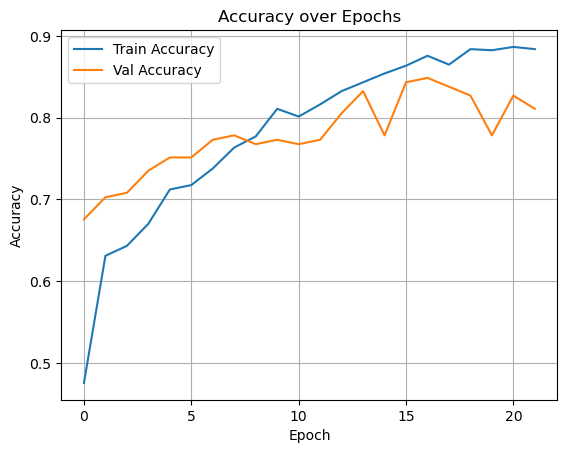

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Confusion Matrix:
[[65 19  2]
 [ 7 48  0]
 [ 0  0 44]]

Classification Report:
              precision    recall  f1-score   support

     label_1       0.90      0.76      0.82        86
     label_2       0.72      0.87      0.79        55
     label_5       0.96      1.00      0.98        44

    accuracy                           0.85       185
   macro avg       0.86      0.88      0.86       185
weighted avg       0.86      0.85      0.85       185



In [17]:
for axis in ['x', 'y', 'z']:
    base = df[f'{axis}_0']
    for i in range(21):
        df[f'{axis}_{i}'] = df[f'{axis}_{i}'] - base

df = df[df['Gesture'].isin([1, 2, 5])].copy()
label_map = {1: 0, 2: 1, 5: 2}
df['label'] = df['Gesture'].map(label_map)

xyz_cols = [col for col in df.columns if col.startswith(('x_', 'y_', 'z_'))]
vel_cols = [col for col in df.columns if col.startswith('vel_')]
angle_cols = [col for col in df.columns if col.startswith('angle_')]
all_feature_cols = xyz_cols + vel_cols + angle_cols

scaler = StandardScaler()
df[all_feature_cols] = scaler.fit_transform(df[all_feature_cols])

def create_sequences(df, feature_cols, window_size=30, step=5):
    X, y = [], []
    data = df[feature_cols].values
    labels = df['label'].values
    for i in range(0, len(df) - window_size + 1, step):
        X.append(data[i:i+window_size])
        y.append(labels[i+window_size - 1])
    return np.array(X), np.array(y)

X_seq, y_seq = create_sequences(df, all_feature_cols)

X_train, X_val, y_train, y_val = train_test_split(
    X_seq, y_seq, test_size=0.2, stratify=y_seq, random_state=42
)
y_train_cat = to_categorical(y_train, num_classes=3)
y_val_cat = to_categorical(y_val, num_classes=3)

cw = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(cw))

model = Sequential([
    LSTM(32, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False),
    Dropout(0.5),                 
    Dense(32, activation='relu'),
    Dropout(0.3),                
    Dense(3, activation='softmax')  
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_lstm_model.h5', monitor='val_accuracy', save_best_only=True, verbose=1)

history = model.fit(
    X_train, y_train_cat,
    validation_data=(X_val, y_val_cat),
    epochs=50,
    batch_size=32,
    class_weight=class_weights,
    callbacks=[early_stop, checkpoint],
    verbose=1
)

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.show()

y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_val_cat, axis=1)

print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred_classes))

print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=["label_1", "label_2", "label_5"]))

In [19]:
for axis in ['x', 'y', 'z']:
    base = df[f'{axis}_0']
    for i in range(21):
        df[f'{axis}_{i}'] = df[f'{axis}_{i}'] - base

df = df[df['Gesture'].isin([1, 2, 5])].copy()
label_map = {1: 0, 2: 1, 5: 2}
df['label'] = df['Gesture'].map(label_map)

xyz_cols = [col for col in df.columns if col.startswith(('x_', 'y_', 'z_'))]
vel_cols = [col for col in df.columns if col.startswith('vel_')]
angle_cols = [col for col in df.columns if col.startswith('angle_')]
all_feature_cols = xyz_cols + vel_cols + angle_cols

scaler = StandardScaler()
df[all_feature_cols] = scaler.fit_transform(df[all_feature_cols])

def create_sequences(df, feature_cols, window_size=30, step=5):
    X, y = [], []
    data = df[feature_cols].values
    labels = df['label'].values
    for i in range(0, len(df) - window_size + 1, step):
        X.append(data[i:i+window_size])
        y.append(labels[i+window_size - 1])
    return np.array(X), np.array(y)

window_sizes = [30, 50, 70]   
step_ratio = 0.2              

results = {}

for ws in window_sizes:
    step = max(1, int(ws * step_ratio))
    print(f"\n=== Window Size: {ws}, Step: {step} ===")

    X_seq, y_seq = create_sequences(df, all_feature_cols, window_size=ws, step=step)

    print(f"Shape: X={X_seq.shape}, y={y_seq.shape}")

    X_train, X_val, y_train, y_val = train_test_split(
        X_seq, y_seq, test_size=0.2, stratify=y_seq, random_state=42
    )

    num_classes = len(np.unique(y_seq))
    y_train_cat = to_categorical(y_train, num_classes=num_classes)
    y_val_cat = to_categorical(y_val, num_classes=num_classes)

    cw = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    class_weights = dict(enumerate(cw))

    model = Sequential([
        LSTM(32, input_shape=(ws, X_train.shape[2])),
        Dropout(0.5),
        Dense(32, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    early_stop = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

    history = model.fit(
        X_train, y_train_cat,
        validation_data=(X_val, y_val_cat),
        epochs=50,
        batch_size=32,
        class_weight=class_weights,
        callbacks=[early_stop],
        verbose=1
    )

    best_val_acc = max(history.history['val_accuracy'])
    print(f"Best Val Accuracy: {best_val_acc:.4f}")

    results[ws] = best_val_acc

print("\n=== Comparison ===")
for ws, acc in results.items():
    print(f"Window Size {ws}: Val Accuracy = {acc:.4f}")


=== Window Size: 30, Step: 6 ===
Shape: X=(771, 30, 131), y=(771,)
Epoch 1/50


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.4474 - loss: 1.0372 - val_accuracy: 0.6516 - val_loss: 0.8263
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6432 - loss: 0.7518 - val_accuracy: 0.6710 - val_loss: 0.7260
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6766 - loss: 0.6610 - val_accuracy: 0.6710 - val_loss: 0.6788
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6959 - loss: 0.6245 - val_accuracy: 0.6968 - val_loss: 0.6218
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6947 - loss: 0.5881 - val_accuracy: 0.7032 - val_loss: 0.6106
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7230 - loss: 0.5339 - val_accuracy: 0.7484 - val_loss: 0.5832
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7509 - loss: 0.5018 - val_accuracy: 0.7419 - val_loss: 0.5622
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7555 - loss: 0.4620 - val_accuracy: 0.7419 - val_loss: 0.5386
Epo

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.3351 - loss: 1.1249 - val_accuracy: 0.6344 - val_loss: 0.9588
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5527 - loss: 0.8948 - val_accuracy: 0.6452 - val_loss: 0.8461
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5630 - loss: 0.7940 - val_accuracy: 0.6882 - val_loss: 0.7696
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6292 - loss: 0.7052 - val_accuracy: 0.6344 - val_loss: 0.7168
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6549 - loss: 0.6487 - val_accuracy: 0.6452 - val_loss: 0.6758
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6966 - loss: 0.6226 - val_accuracy: 0.6452 - val_loss: 0.6486
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6821 - loss: 0.5597 - val_accuracy: 0.6667 - val_loss: 0.6311
Epoch 8/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6890 - loss: 0.5859 - val_accuracy: 0.6882 - val_loss: 0.6077
Be

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.2283 - loss: 1.3825 - val_accuracy: 0.3333 - val_loss: 1.1268
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4068 - loss: 1.0895 - val_accuracy: 0.5455 - val_loss: 1.0151
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5349 - loss: 0.9504 - val_accuracy: 0.6061 - val_loss: 0.9218
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6056 - loss: 0.8798 - val_accuracy: 0.6667 - val_loss: 0.8499
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6372 - loss: 0.7809 - val_accuracy: 0.6818 - val_loss: 0.7807
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5935 - loss: 0.7809 - val_accuracy: 0.6818 - val_loss: 0.7336
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6351 - loss: 0.7288 - val_accuracy: 0.6970 - val_loss: 0.6967
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6745 - loss: 0.6515 - val_accuracy: 0.7121 - val_loss: 0.6587
Epoch 9/50
9/9 ━━━

Epoch 1/50


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3242 - loss: 1.1370  
Epoch 1: val_accuracy improved from -inf to 0.60645, saving model to best_lstm_model.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.3332 - loss: 1.1278 - val_accuracy: 0.6065 - val_loss: 0.8874
Epoch 2/50
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5540 - loss: 0.8399 
Epoch 2: val_accuracy improved from 0.60645 to 0.64516, saving model to best_lstm_model.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5567 - loss: 0.8349 - val_accuracy: 0.6452 - val_loss: 0.7522
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6319 - loss: 0.7073
Epoch 3: val_accuracy improved from 0.64516 to 0.67742, saving model to best_lstm_model.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6329 - loss: 0.7061 - val_accuracy: 0.6774 - val_loss: 0.6702
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6901 - loss: 0.6218 
Epoch 4: val_accuracy did not improve from 0.67742
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6908 - loss: 0.6207 - val_accuracy: 0.6710 - val_loss: 0.6266
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6772 - loss: 0.5918
Epoch 5: val_accuracy improved from 0.67742 to 0.68387, saving model to best_lstm_model.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6767 - loss: 0.5916 - val_accuracy: 0.6839 - val_loss: 0.6196
Epoch 6/50
13/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6555 - loss: 0.5480 
Epoch 6: val_accuracy improved from 0.68387 to 0.73548, saving model to best_lstm_model.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6753 - loss: 0.5487 - val_accuracy: 0.7355 - val_loss: 0.5746
Epoch 7/50
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7530 - loss: 0.5146 
Epoch 7: val_accuracy did not improve from 0.73548
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7528 - loss: 0.5131 - val_accuracy: 0.7355 - val_loss: 0.5590
Epoch 8/50
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7466 - loss: 0.5014
Epoch 8: val_accuracy improved from 0.73548 to 0.76129, saving model to best_lstm_model.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7462 - loss: 0.5011 - val_accuracy: 0.7613 - val_loss: 0.5263
Epoch 9/50
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7804 - loss: 0.4572
Epoch 9: val_accuracy improved from 0.76129 to 0.78065, saving model to best_lstm_model.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7792 - loss: 0.4552 - val_accuracy: 0.7806 - val_loss: 0.5014
Epoch 10/50
18/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8078 - loss: 0.4033
Epoch 10: val_accuracy did not improve from 0.78065
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8074 - loss: 0.4057 - val_accuracy: 0.7742 - val_loss: 0.4703
Epoch 11/50
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7780 - loss: 0.4363
Epoch 11: val_accuracy did not improve from 0.78065
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7781 - loss: 0.4351 - val_accuracy: 0.7677 - val_loss: 0.4706
Epoch 12/50
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8045 - loss: 0.4052
Epoch 12: val_accuracy improved from 0.78065 to 0.79355, saving model to best_lstm_model.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8052 - loss: 0.4042 - val_accuracy: 0.7935 - val_loss: 0.4565
Epoch 13/50
18/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8245 - loss: 0.3732 
Epoch 13: val_accuracy improved from 0.79355 to 0.81290, saving model to best_lstm_model.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8268 - loss: 0.3714 - val_accuracy: 0.8129 - val_loss: 0.4506
Epoch 14/50
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8624 - loss: 0.3384
Epoch 14: val_accuracy did not improve from 0.81290
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8603 - loss: 0.3404 - val_accuracy: 0.8000 - val_loss: 0.4504
Epoch 15/50
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8292 - loss: 0.3665
Epoch 15: val_accuracy did not improve from 0.81290
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8293 - loss: 0.3651 - val_accuracy: 0.8000 - val_loss: 0.4322
Epoch 16/50
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8199 - loss: 0.3541
Epoch 16: val_accuracy improved from 0.81290 to 0.83871, saving model to best_lstm_model.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8210 - loss: 0.3538 - val_accuracy: 0.8387 - val_loss: 0.3962
Epoch 17/50
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8536 - loss: 0.3430 
Epoch 17: val_accuracy improved from 0.83871 to 0.84516, saving model to best_lstm_model.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8549 - loss: 0.3404 - val_accuracy: 0.8452 - val_loss: 0.3831
Epoch 18/50
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8650 - loss: 0.3073 
Epoch 18: val_accuracy did not improve from 0.84516
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8649 - loss: 0.3065 - val_accuracy: 0.8387 - val_loss: 0.3756
Epoch 19/50
18/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8401 - loss: 0.3562
Epoch 19: val_accuracy did not improve from 0.84516
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8443 - loss: 0.3488 - val_accuracy: 0.8129 - val_loss: 0.4799
Epoch 20/50
10/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8164 - loss: 0.3560
Epoch 20: val_accuracy did not improve from 0.84516
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8340 - loss: 0.3292 - val_accuracy: 0.8387 - val_loss: 0.3672
Epoch 21/50
18/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8708 - loss: 0.2608 
Epoch 21: val_accuracy did not improve fro

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8781 - loss: 0.2607 - val_accuracy: 0.8581 - val_loss: 0.3312
Epoch 23/50
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9052 - loss: 0.2295 
Epoch 23: val_accuracy did not improve from 0.85806
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9040 - loss: 0.2323 - val_accuracy: 0.8516 - val_loss: 0.3700
Epoch 24/50
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8501 - loss: 0.3359
Epoch 24: val_accuracy did not improve from 0.85806
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8509 - loss: 0.3321 - val_accuracy: 0.8516 - val_loss: 0.3459
Epoch 25/50
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8852 - loss: 0.2750
Epoch 25: val_accuracy improved from 0.85806 to 0.86452, saving model to best_lstm_model.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8870 - loss: 0.2727 - val_accuracy: 0.8645 - val_loss: 0.3882
Epoch 26/50
18/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9042 - loss: 0.2095 
Epoch 26: val_accuracy did not improve from 0.86452
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9035 - loss: 0.2116 - val_accuracy: 0.8452 - val_loss: 0.3628
Epoch 27/50
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9031 - loss: 0.2258
Epoch 27: val_accuracy did not improve from 0.86452
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9040 - loss: 0.2247 - val_accuracy: 0.8387 - val_loss: 0.3909
Epoch 28/50
18/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9149 - loss: 0.2179
Epoch 28: val_accuracy did not improve from 0.86452
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9129 - loss: 0.2202 - val_accuracy: 0.8323 - val_loss: 0.3610
Epoch 29/50
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9066 - loss: 0.1946
Epoch 29: val_accuracy did not improve from

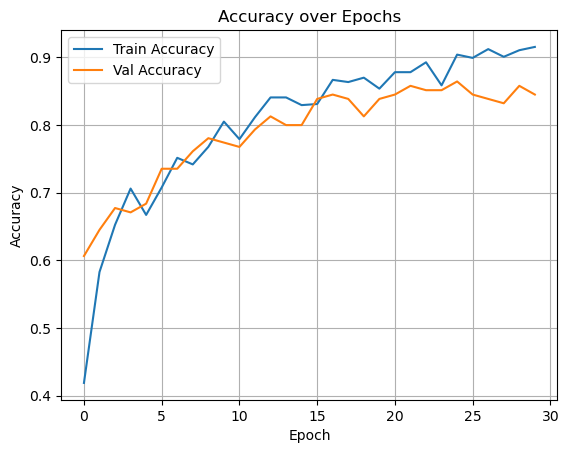

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Confusion Matrix:
[[55 16  1]
 [ 3 43  0]
 [ 1  0 36]]

Classification Report:
              precision    recall  f1-score   support

     label_1       0.93      0.76      0.84        72
     label_2       0.73      0.93      0.82        46
     label_5       0.97      0.97      0.97        37

    accuracy                           0.86       155
   macro avg       0.88      0.89      0.88       155
weighted avg       0.88      0.86      0.87       155



In [15]:
for axis in ['x', 'y', 'z']:
    base = df[f'{axis}_0']
    for i in range(21):
        df[f'{axis}_{i}'] = df[f'{axis}_{i}'] - base
        
df = df[df['Gesture'].isin([1, 2, 5])].copy()
label_map = {1: 0, 2: 1, 5: 2}
df['label'] = df['Gesture'].map(label_map)

xyz_cols = [col for col in df.columns if col.startswith(('x_', 'y_', 'z_'))]
vel_cols = [col for col in df.columns if col.startswith('vel_')]
angle_cols = [col for col in df.columns if col.startswith('angle_')]
all_feature_cols = xyz_cols + vel_cols + angle_cols

scaler = StandardScaler()
df[all_feature_cols] = scaler.fit_transform(df[all_feature_cols])

def create_sequences(df, feature_cols, window_size=30, step=6):
    X, y = [], []
    data = df[feature_cols].values
    labels = df['label'].values
    for i in range(0, len(df) - window_size + 1, step):
        X.append(data[i:i+window_size])
        y.append(labels[i+window_size - 1])
    return np.array(X), np.array(y)

X_seq, y_seq = create_sequences(df, all_feature_cols)

X_train, X_val, y_train, y_val = train_test_split(
    X_seq, y_seq, test_size=0.2, stratify=y_seq, random_state=42
)
y_train_cat = to_categorical(y_train, num_classes=3)
y_val_cat = to_categorical(y_val, num_classes=3)

cw = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(cw))

model = Sequential([
    LSTM(32, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False),
    Dropout(0.5),                 
    Dense(32, activation='relu'), 
    Dropout(0.3),                 
    Dense(3, activation='softmax') 
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# STEP 10: Callbacks
early_stop = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_lstm_model.h5', monitor='val_accuracy', save_best_only=True, verbose=1)

# STEP 11: Train
history = model.fit(
    X_train, y_train_cat,
    validation_data=(X_val, y_val_cat),
    epochs=50,
    batch_size=32,
    class_weight=class_weights,
    callbacks=[early_stop, checkpoint],
    verbose=1
)

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.show()

y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_val_cat, axis=1)

print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred_classes))

print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=["label_1", "label_2", "label_5"]))

Epoch 1/50


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2802 - loss: 1.2120   
Epoch 1: val_accuracy improved from -inf to 0.53548, saving model to best_lstm_model.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.2830 - loss: 1.2072 - val_accuracy: 0.5355 - val_loss: 0.9001
Epoch 2/50
10/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4847 - loss: 0.8827
Epoch 2: val_accuracy improved from 0.53548 to 0.63871, saving model to best_lstm_model.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5106 - loss: 0.8474 - val_accuracy: 0.6387 - val_loss: 0.7793
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6247 - loss: 0.7018 
Epoch 3: val_accuracy improved from 0.63871 to 0.70968, saving model to best_lstm_model.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6248 - loss: 0.7013 - val_accuracy: 0.7097 - val_loss: 0.7093
Epoch 4/50
18/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6454 - loss: 0.6829 
Epoch 4: val_accuracy improved from 0.70968 to 0.72903, saving model to best_lstm_model.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6478 - loss: 0.6766 - val_accuracy: 0.7290 - val_loss: 0.6599
Epoch 5/50
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6784 - loss: 0.5826 
Epoch 5: val_accuracy improved from 0.72903 to 0.74194, saving model to best_lstm_model.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6798 - loss: 0.5823 - val_accuracy: 0.7419 - val_loss: 0.6271
Epoch 6/50
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7036 - loss: 0.5291 
Epoch 6: val_accuracy improved from 0.74194 to 0.74839, saving model to best_lstm_model.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7033 - loss: 0.5316 - val_accuracy: 0.7484 - val_loss: 0.5969
Epoch 7/50
18/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7328 - loss: 0.5180 
Epoch 7: val_accuracy did not improve from 0.74839
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7287 - loss: 0.5193 - val_accuracy: 0.7484 - val_loss: 0.5989
Epoch 8/50
 9/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7451 - loss: 0.5528
Epoch 8: val_accuracy improved from 0.74839 to 0.76774, saving model to best_lstm_model.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7433 - loss: 0.5314 - val_accuracy: 0.7677 - val_loss: 0.5465
Epoch 9/50
18/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7262 - loss: 0.4929 
Epoch 9: val_accuracy improved from 0.76774 to 0.77419, saving model to best_lstm_model.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7309 - loss: 0.4908 - val_accuracy: 0.7742 - val_loss: 0.5486
Epoch 10/50
18/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7401 - loss: 0.4654 
Epoch 10: val_accuracy did not improve from 0.77419
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7419 - loss: 0.4655 - val_accuracy: 0.7677 - val_loss: 0.5383
Epoch 11/50
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7958 - loss: 0.4190
Epoch 11: val_accuracy improved from 0.77419 to 0.81290, saving model to best_lstm_model.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7950 - loss: 0.4196 - val_accuracy: 0.8129 - val_loss: 0.4898
Epoch 12/50
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8055 - loss: 0.4030 
Epoch 12: val_accuracy did not improve from 0.81290
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8044 - loss: 0.4051 - val_accuracy: 0.7806 - val_loss: 0.4786
Epoch 13/50
18/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8012 - loss: 0.4295
Epoch 13: val_accuracy did not improve from 0.81290
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8012 - loss: 0.4265 - val_accuracy: 0.8065 - val_loss: 0.4423
Epoch 14/50
18/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7848 - loss: 0.4052 
Epoch 14: val_accuracy did not improve from 0.81290
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7867 - loss: 0.4036 - val_accuracy: 0.8000 - val_loss: 0.4424
Epoch 15/50
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7987 - loss: 0.3678 
Epoch 15: val_accuracy did not improve fr

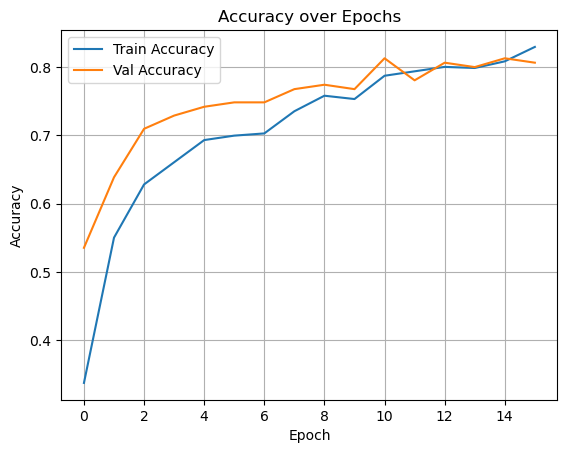

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Confusion Matrix:
[[60 11  1]
 [14 32  0]
 [ 2  1 34]]

Classification Report:
              precision    recall  f1-score   support

     label_1       0.79      0.83      0.81        72
     label_2       0.73      0.70      0.71        46
     label_5       0.97      0.92      0.94        37

    accuracy                           0.81       155
   macro avg       0.83      0.82      0.82       155
weighted avg       0.81      0.81      0.81       155



In [17]:
for axis in ['x', 'y', 'z']:
    base = df[f'{axis}_0']
    for i in range(21):
        df[f'{axis}_{i}'] = df[f'{axis}_{i}'] - base

df = df[df['Gesture'].isin([1, 2, 5])].copy()
label_map = {1: 0, 2: 1, 5: 2}
df['label'] = df['Gesture'].map(label_map)

xyz_cols = [col for col in df.columns if col.startswith(('x_', 'y_', 'z_'))]
vel_cols = [col for col in df.columns if col.startswith('vel_')]
angle_cols = [col for col in df.columns if col.startswith('angle_')]
all_feature_cols = xyz_cols + vel_cols + angle_cols

scaler = StandardScaler()
df[all_feature_cols] = scaler.fit_transform(df[all_feature_cols])

def create_sequences(df, feature_cols, window_size=30, step=6):
    X, y = [], []
    data = df[feature_cols].values
    labels = df['label'].values
    for i in range(0, len(df) - window_size + 1, step):
        X.append(data[i:i+window_size])
        y.append(labels[i+window_size - 1])
    return np.array(X), np.array(y)

X_seq, y_seq = create_sequences(df, all_feature_cols)

X_train, X_val, y_train, y_val = train_test_split(
    X_seq, y_seq, test_size=0.2, stratify=y_seq, random_state=42
)
y_train_cat = to_categorical(y_train, num_classes=3)
y_val_cat = to_categorical(y_val, num_classes=3)

cw = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(cw))

model = Sequential([
    LSTM(32, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False),
    Dropout(0.5),                 
    Dense(32, activation='relu'),
    Dropout(0.3),                 
    Dense(3, activation='softmax') 
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_lstm_model.h5', monitor='val_accuracy', save_best_only=True, verbose=1)

history = model.fit(
    X_train, y_train_cat,
    validation_data=(X_val, y_val_cat),
    epochs=50,
    batch_size=32,
    class_weight=class_weights,
    callbacks=[early_stop, checkpoint],
    verbose=1
)

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.show()

y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_val_cat, axis=1)

print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred_classes))

print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=["label_1", "label_2", "label_5"]))